# ECE521 Assignment 1

In [69]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1 Logistic Regression

## 1.1 Binary cross-entropy loss

In [70]:
with np.load("../data/notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data, Target = Data[randIndx], Target[randIndx]
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]
    
    trainData = trainData.reshape(trainData.shape[0],-1)
    validData = validData.reshape(validData.shape[0],-1)
    testData = testData.reshape(testData.shape[0],-1)
    
#     print trainData.shape
#     print trainTarget.shape
#     print validData.shape
#     print validTarget.shape
#     print testData.shape
#     print testTarget.shape

### 1.1.1

In [72]:
def buildGraph_SGD(decay_rate, learning_rate):
    # Variable creation
    W = tf.Variable(tf.truncated_normal(shape=[784,1], stddev=0.5), name='weights')
    b = tf.Variable(0.0, name='biases')
    X = tf.placeholder(tf.float32, [None, 784], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,1], name='target_y')

    # Graph definition
    y_predicted = tf.matmul(X,W) + b

    # Error definition
    error = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(targets = y_target, logits = y_predicted)) + \
             0.5 * decay_rate * tf.reduce_sum(tf.cast(tf.square(W), tf.float32))

    acc = tf.reduce_mean(tf.cast(tf.equal(y_target, tf.cast((tf.sigmoid(y_predicted) > 0.5), tf.float32)),tf.float32))
    # Training mechanism
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return W, b, X, y_target, y_predicted, error, train, acc

def getRandomBatch(trainData, trainTarget, size):
    idx = np.random.choice(trainData.shape[0], size, replace=False)
    return trainData[idx,:], trainTarget[idx,:]
# fix figure size
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


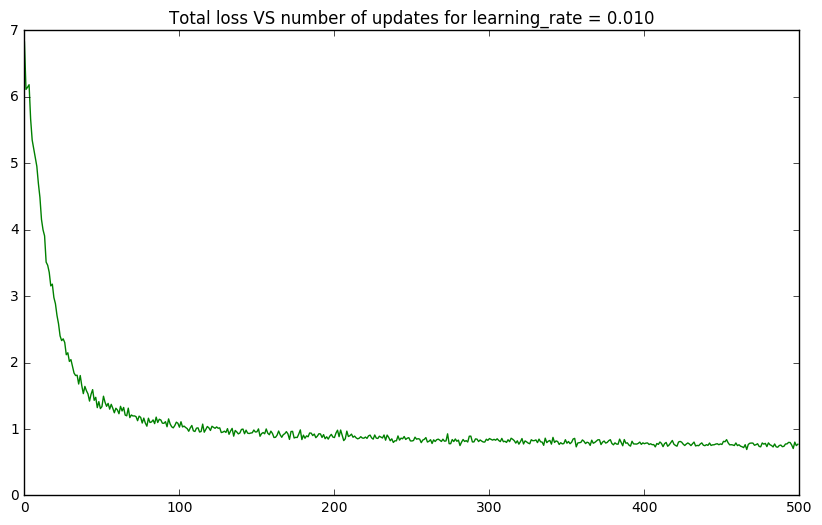

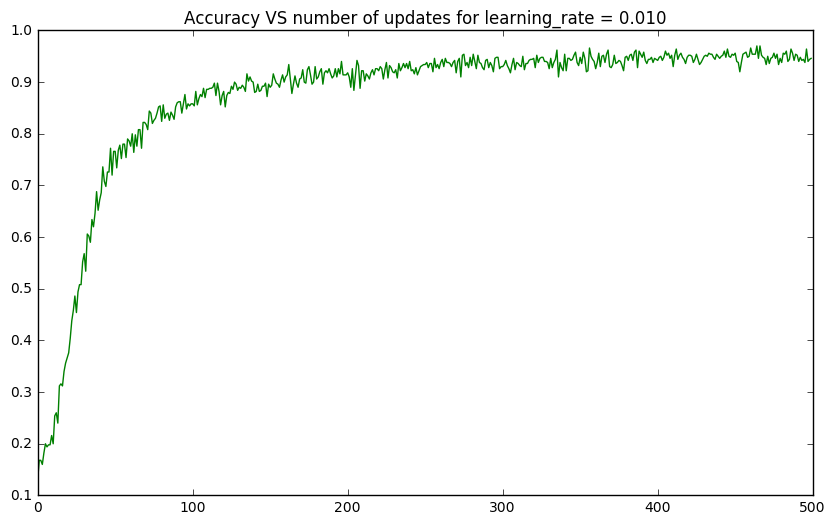

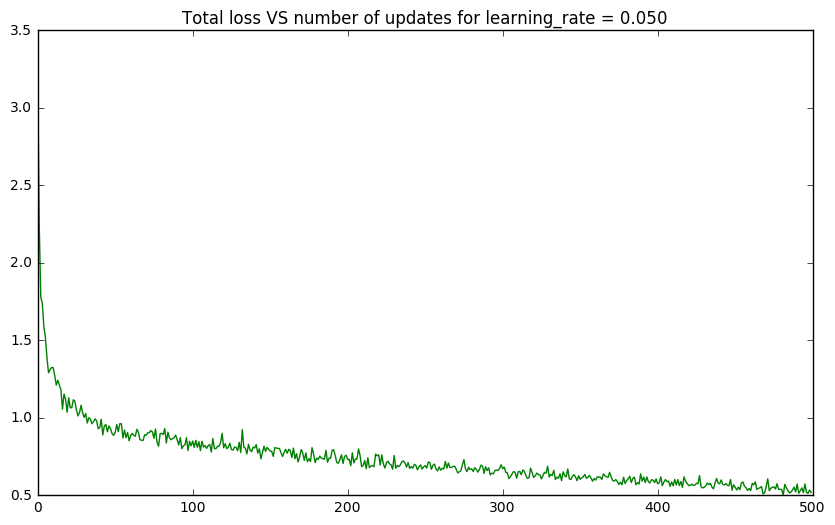

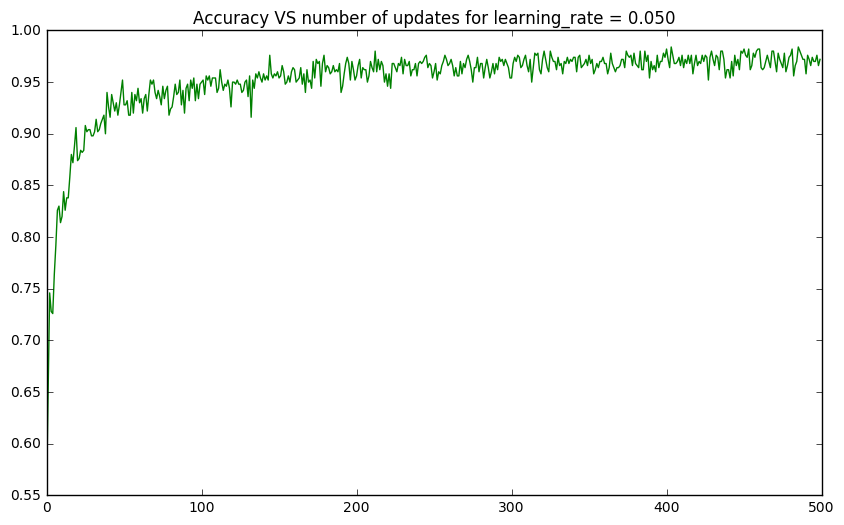

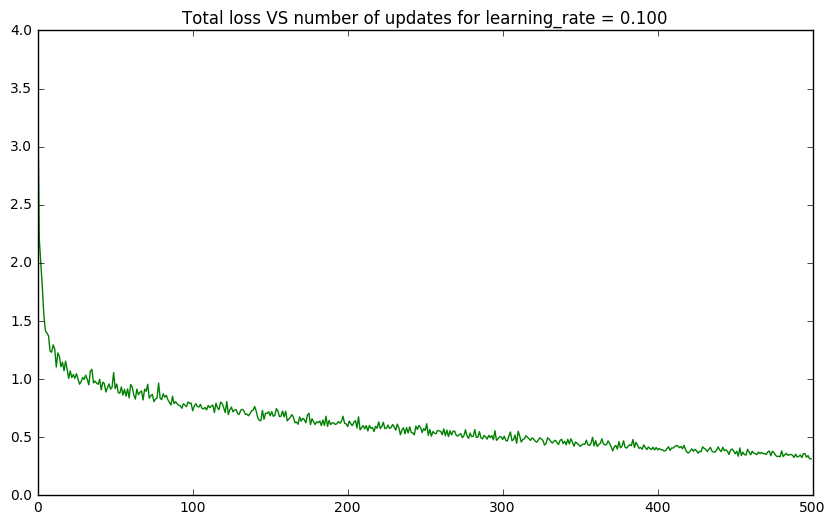

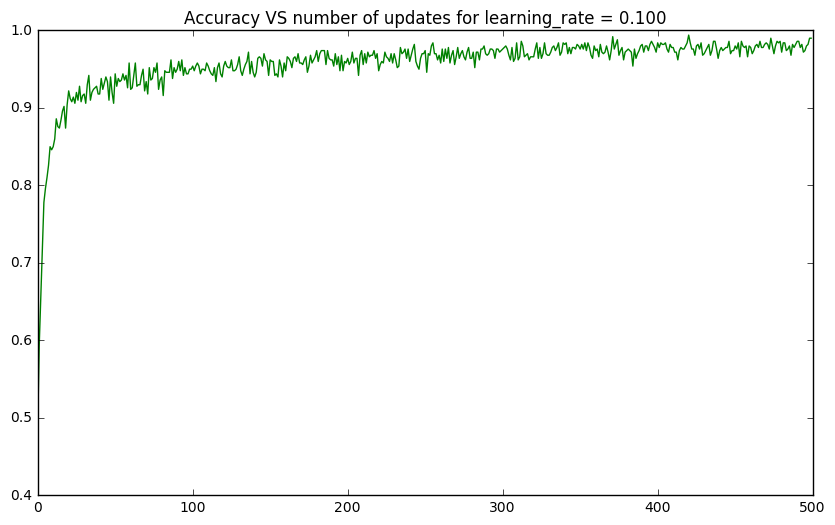

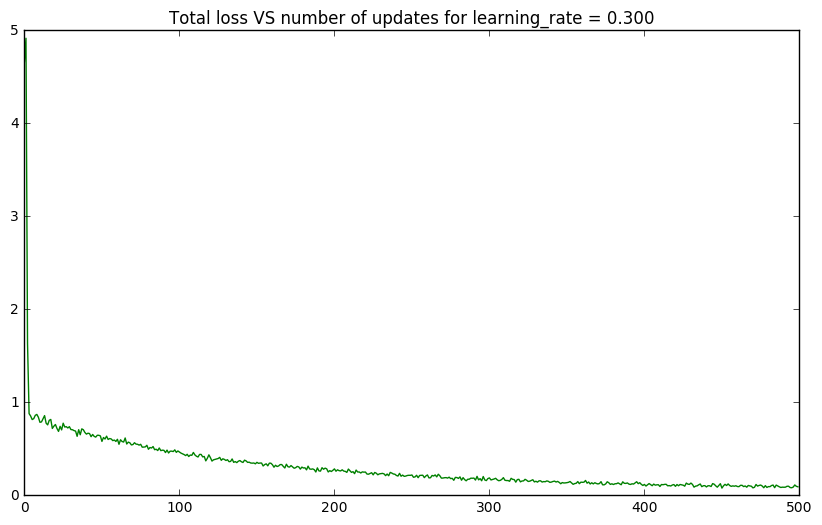

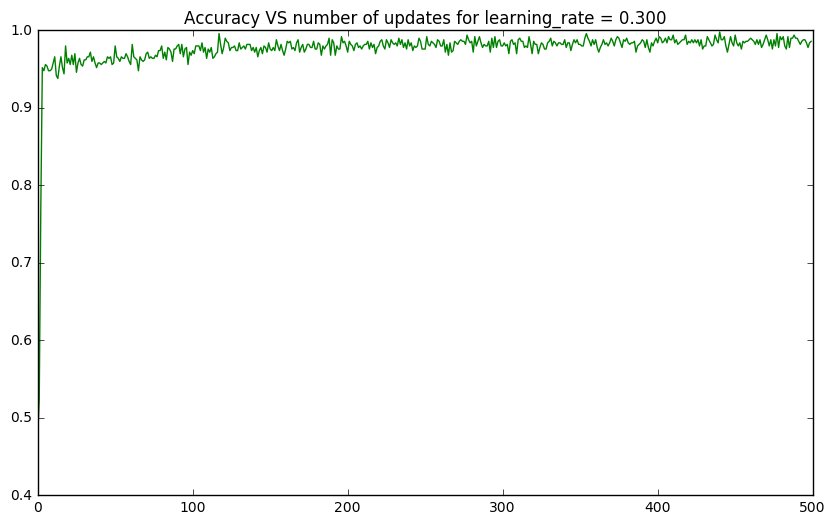

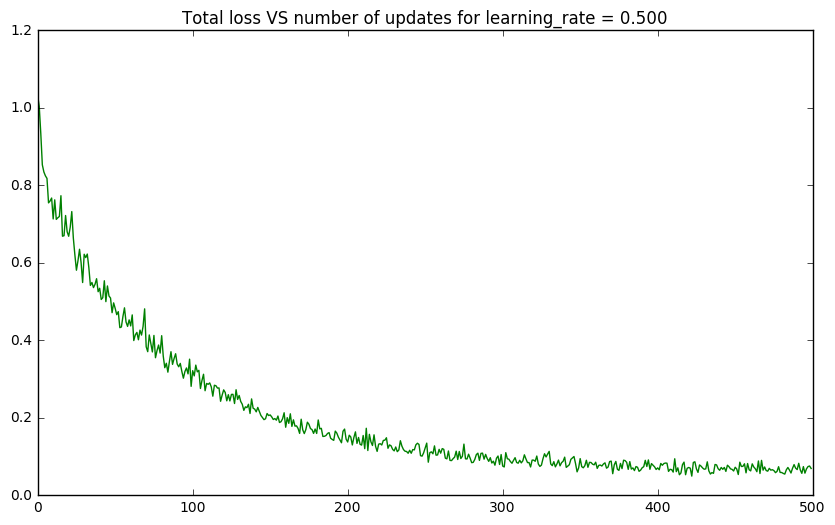

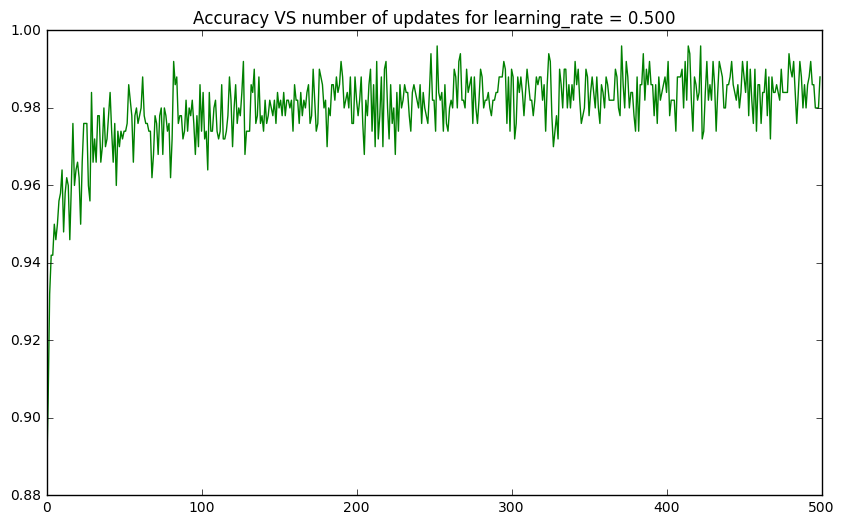

In [73]:
decay_rate = 0.01
batch_size = 500
learning_rate_list = [ 0.01, 0.05, 0.1, 0.3, 0.5]
for learning_rate in learning_rate_list: 
    W, b, X, y_target, y_predicted, error, train, acc = buildGraph_SGD(decay_rate, learning_rate)
    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    acc_recorder = np.array([])
    
    numIteration = 500
    for itr in range(numIteration):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
        loss_recorder = np.append(loss_recorder, loss)
        acc_recorder = np.append(acc_recorder, accuracy)
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
    plt.show()
    
    plt.plot(np.arange(numIteration), acc_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Accuracy VS number of updates for learning_rate = %0.3f"%(learning_rate))
    plt.show()

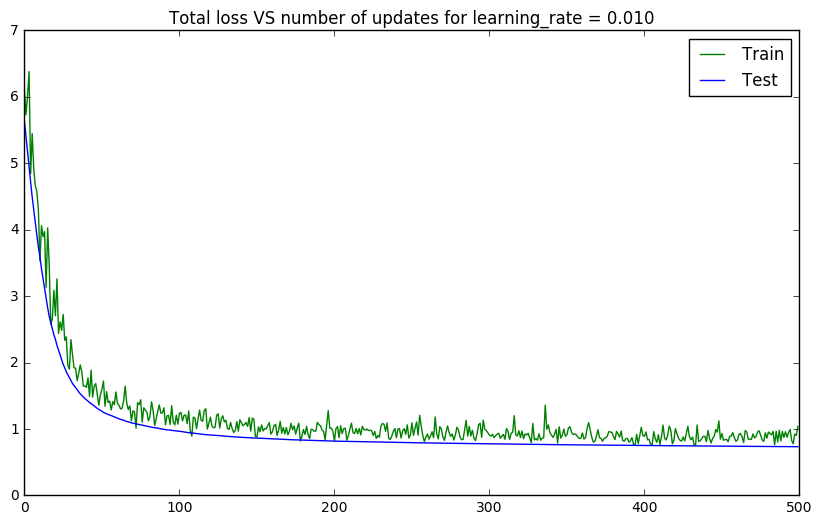

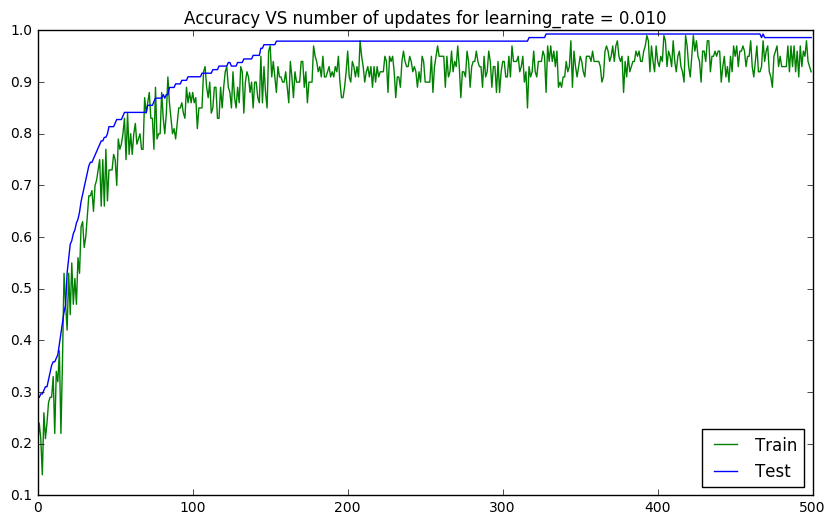

Best accuracy in test set is 0.99


In [78]:
decay_rate = 0.01
batch_size = 100
learning_rate = 0.01
#best learning rate 0.01
W, b, X, y_target, y_predicted, error, train, acc = buildGraph_SGD(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
train_loss_recorder = np.array([])
train_acc_recorder = np.array([])
test_loss_recorder = np.array([])
test_acc_recorder = np.array([])
numIteration = 500
best_acc = 0
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    train_loss_recorder = np.append(train_loss_recorder, loss)
    train_acc_recorder = np.append(train_acc_recorder, accuracy)
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    test_loss_recorder = np.append(test_loss_recorder, test_loss)
    test_acc_recorder = np.append(test_acc_recorder, test_acc)
    best_acc = max(best_acc, test_acc)
plt.plot(np.arange(numIteration), train_loss_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), test_loss_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

plt.plot(np.arange(numIteration), train_acc_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), test_acc_recorder, 'b', label="Test")
plt.legend(loc="lower right")
#plt.axis([0,500, 0, 2])
plt.title("Accuracy VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

print("Best accuracy in test set is %0.2f"%(best_acc))

### 1.1.2

In [111]:
def buildGraph_Adam(decay_rate, learning_rate):
    # Variable creation
    W = tf.Variable(tf.truncated_normal(shape=[784,1], stddev=0.5), name='weights')
    b = tf.Variable(0.0, name='biases')
    X = tf.placeholder(tf.float32, [None, 784], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,1], name='target_y')

    # Graph definition
    y_predicted = tf.matmul(X,W) + b

    # Error definition
    error = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(targets = y_target, logits = y_predicted),
                                  name='mean_squared_error') + \
             0.5 * decay_rate * tf.reduce_sum(tf.cast(tf.square(W), tf.float32))

    acc = tf.reduce_mean(tf.cast(tf.equal(y_target, tf.cast((tf.sigmoid(y_predicted) > 0.5), tf.float32)),tf.float32))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return W, b, X, y_target, y_predicted, error, train, acc

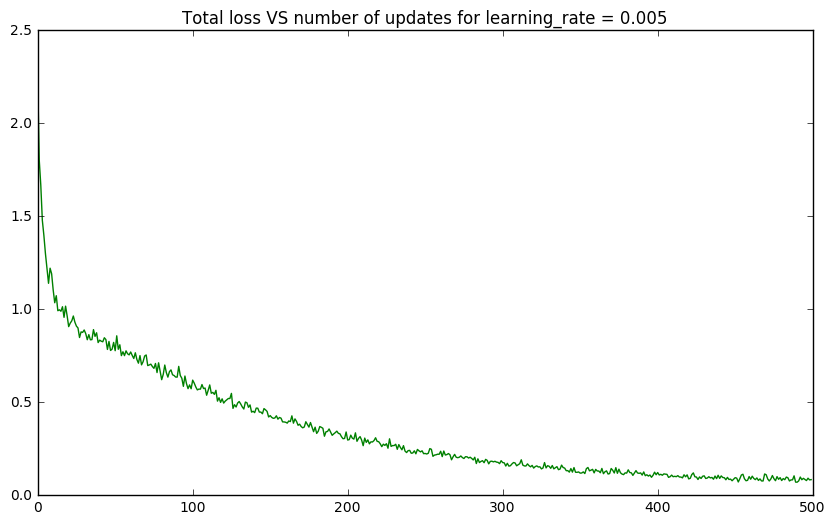

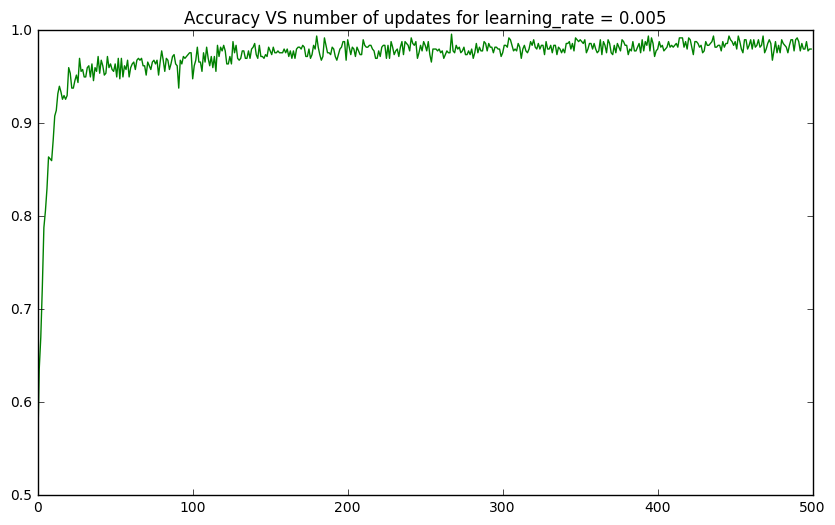

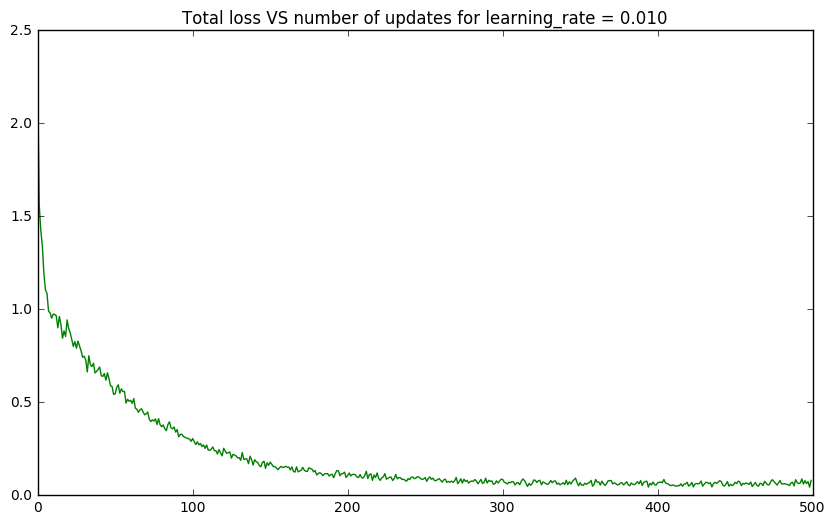

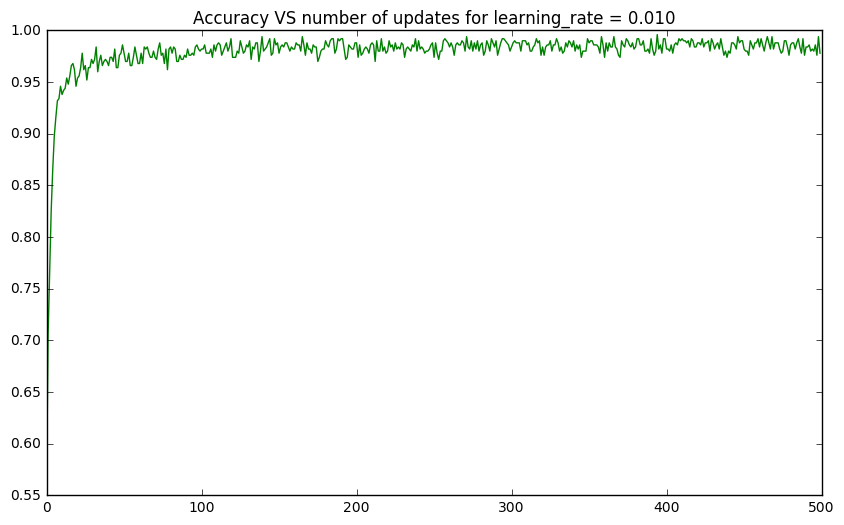

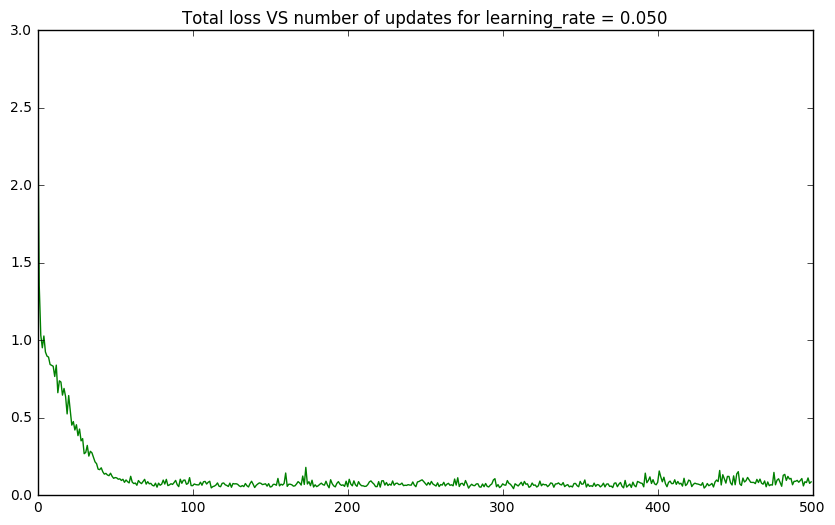

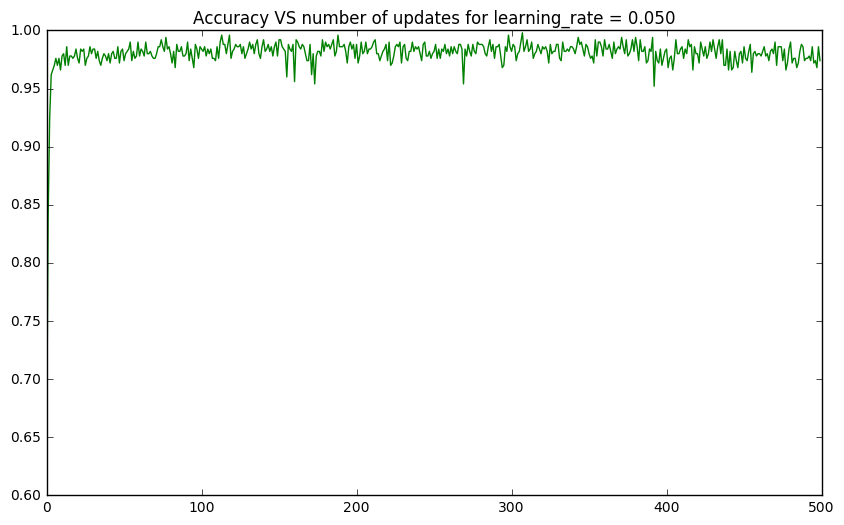

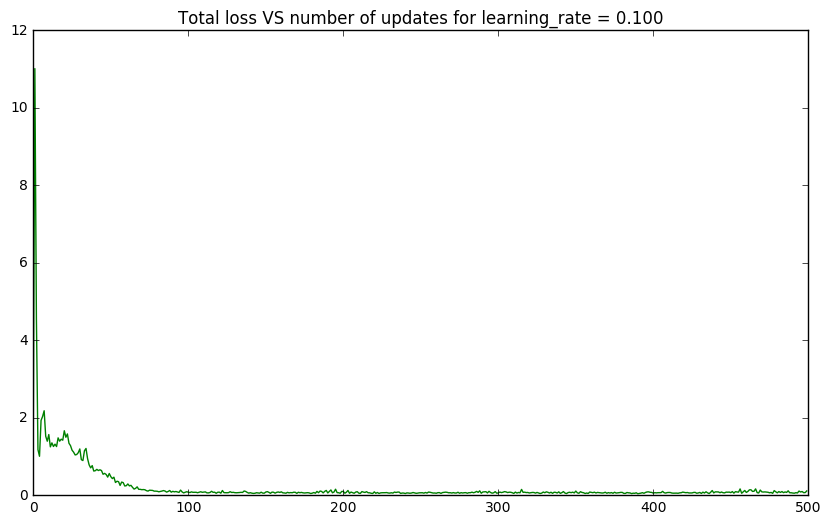

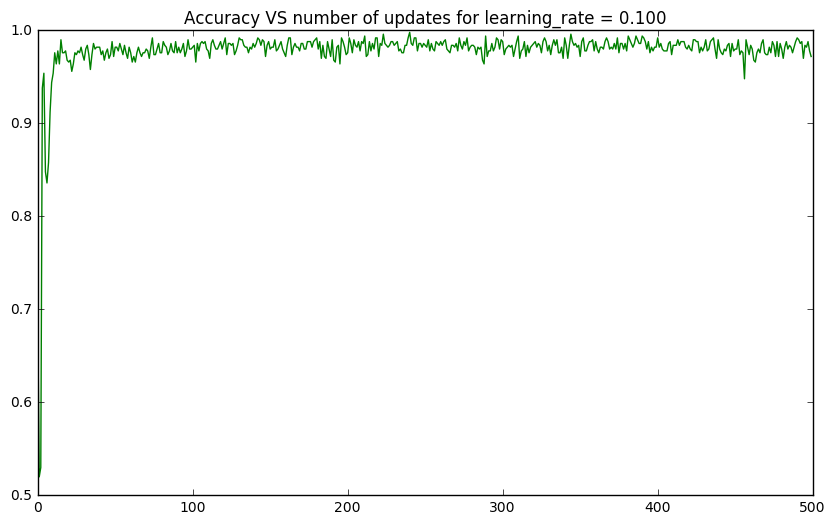

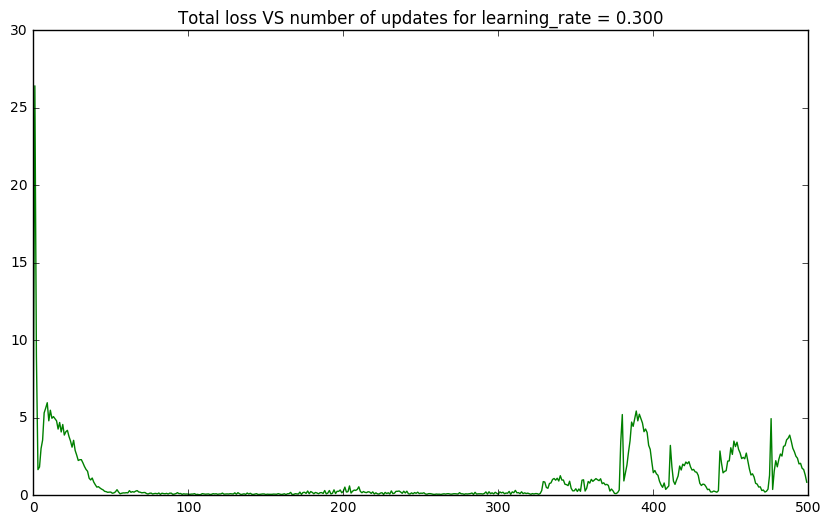

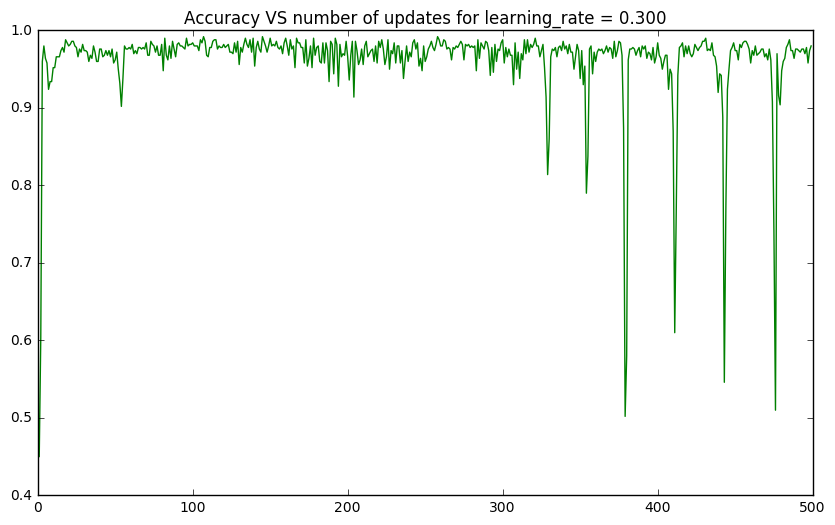

In [112]:
decay_rate = 0.01
batch_size = 500
learning_rate_list = [ 0.005, 0.01, 0.05, 0.1, 0.3]
for learning_rate in learning_rate_list: 
    W, b, X, y_target, y_predicted, error, train, acc = buildGraph_Adam(decay_rate, learning_rate)
    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    acc_recorder = np.array([])
    
    numIteration = 500
    for itr in range(numIteration):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
        loss_recorder = np.append(loss_recorder, loss)
        acc_recorder = np.append(acc_recorder, accuracy)
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
    plt.show()
    
    plt.plot(np.arange(numIteration), acc_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Accuracy VS number of updates for learning_rate = %0.3f"%(learning_rate))
    plt.show()

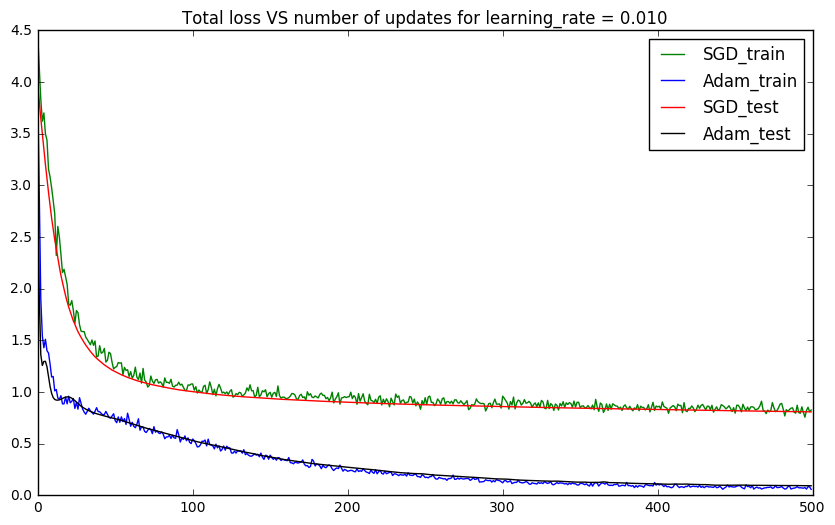

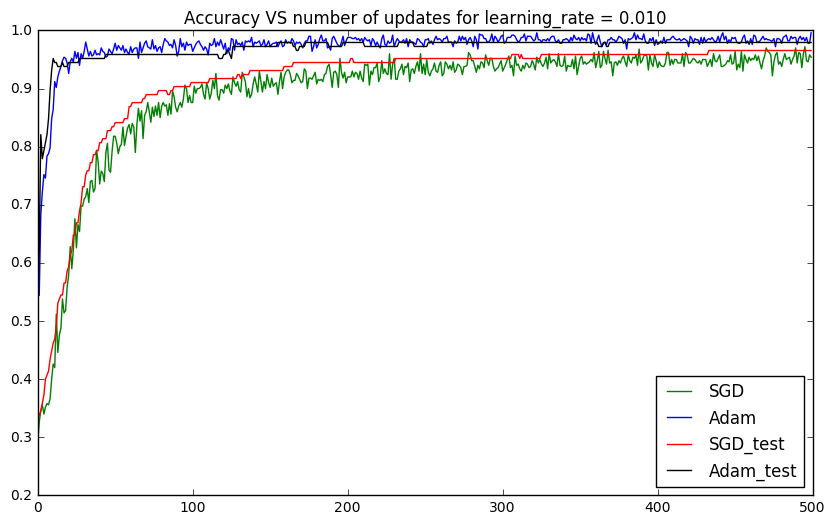

In [113]:
decay_rate = 0.01
batch_size = 500
learning_rate = 0.01
# training using SGD
W, b, X, y_target, y_predicted, error, train, acc = buildGraph_SGD(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
sgd_train_loss_recorder = np.array([])
sgd_train_acc_recorder = np.array([])
sgd_test_loss_recorder = np.array([])
sgd_test_acc_recorder = np.array([])
numIteration = 500
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    sgd_train_loss_recorder = np.append(sgd_train_loss_recorder, loss)
    sgd_train_acc_recorder = np.append(sgd_train_acc_recorder, accuracy)
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    sgd_test_loss_recorder = np.append(sgd_test_loss_recorder, test_loss)
    sgd_test_acc_recorder = np.append(sgd_test_acc_recorder, test_acc)
    
# training using Adam
W, b, X, y_target, y_predicted, error, train, acc = buildGraph_Adam(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
adam_train_loss_recorder = np.array([])
adam_train_acc_recorder = np.array([])
adam_test_loss_recorder = np.array([])
adam_test_acc_recorder = np.array([])
numIteration = 500
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    adam_train_loss_recorder = np.append(adam_train_loss_recorder, loss)
    adam_train_acc_recorder = np.append(adam_train_acc_recorder, accuracy)
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    adam_test_loss_recorder = np.append(adam_test_loss_recorder, test_loss)
    adam_test_acc_recorder = np.append(adam_test_acc_recorder, test_acc)
plt.plot(np.arange(numIteration), sgd_train_loss_recorder, 'g', label="SGD_train")
plt.plot(np.arange(numIteration), adam_train_loss_recorder, 'b', label="Adam_train")
plt.plot(np.arange(numIteration), sgd_test_loss_recorder, 'r', label="SGD_test")
plt.plot(np.arange(numIteration), adam_test_loss_recorder, 'k', label="Adam_test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()
    
plt.plot(np.arange(numIteration), sgd_train_acc_recorder, 'g', label="SGD")
plt.plot(np.arange(numIteration), adam_train_acc_recorder, 'b', label="Adam")
plt.plot(np.arange(numIteration), sgd_test_acc_recorder, 'r', label="SGD_test")
plt.plot(np.arange(numIteration), adam_test_acc_recorder, 'k', label="Adam_test")
plt.legend(loc="lower right")
#plt.axis([0,500, 0, 2])
plt.title("Accuracy VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

<p>Comparing to SGD, Adam optimizer has a faster convergence rate and it has a better ability to find optimums.</p>

<h3>1.1.3</h3>

In [114]:
def buildGraph_linear(decay_rate, learning_rate):
    # Variable creation
    W = tf.Variable(tf.truncated_normal(shape=[784,1], stddev=0.5), name='weights')
    b = tf.Variable(0.0, name='biases')
    X = tf.placeholder(tf.float32, [None, 784], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,1], name='target_y')

    # Graph definition
    y_predicted = tf.matmul(X,W) + b

    # Error definition
    error =  0.5 * tf.reduce_mean(tf.cast(tf.reduce_sum(tf.cast(tf.square(y_predicted - y_target), tf.float32), 
                                                reduction_indices=1, 
                                                name='squared_error'), tf.float32),
                                  name='mean_squared_error') + \
             0.5 * decay_rate * tf.reduce_sum(tf.cast(tf.square(W), tf.float32))
        
    # y_predicted = tf.nn.l2_normalize(y_predicted, 0)
    acc = tf.reduce_mean(tf.cast(tf.equal(y_target, tf.cast(y_predicted > 0.5, tf.float32)),tf.float32))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return W, b, X, y_target, y_predicted, error, train, acc

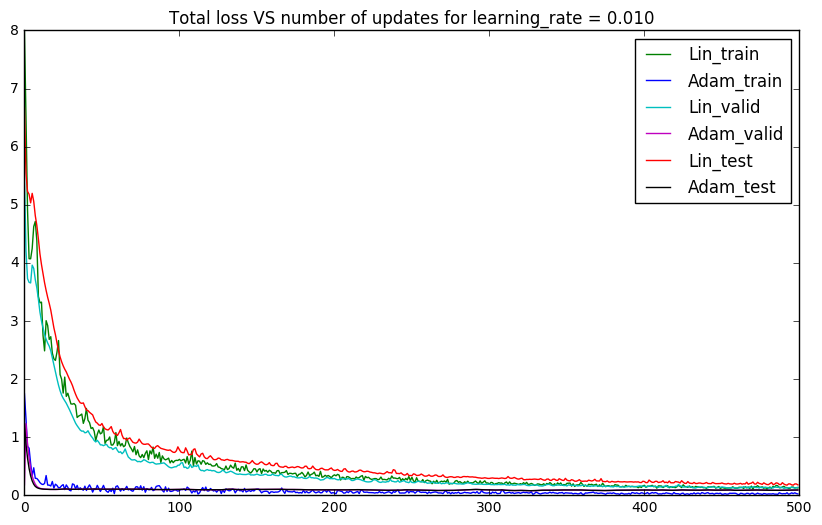

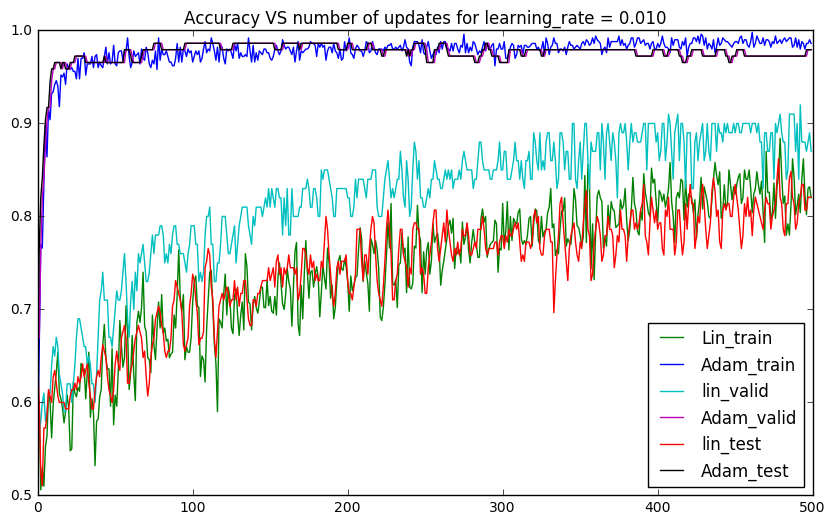

In [110]:
decay_rate = 0
batch_size = 500
learning_rate = 0.01
# training using SGD
W, b, X, y_target, y_predicted, error, train, acc = buildGraph_linear(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
lin_train_loss_recorder = np.array([])
lin_train_acc_recorder = np.array([])
lin_valid_loss_recorder = np.array([])
lin_valid_acc_recorder = np.array([])
lin_test_loss_recorder = np.array([])
lin_test_acc_recorder = np.array([])
numIteration = 500
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    lin_train_loss_recorder = np.append(lin_train_loss_recorder, loss)
    lin_train_acc_recorder = np.append(lin_train_acc_recorder, accuracy)
    valid_loss, valid_acc = sess.run([error, acc], feed_dict={X: validData, y_target: validTarget})
    lin_valid_loss_recorder = np.append(lin_valid_loss_recorder, valid_loss)
    lin_valid_acc_recorder = np.append(lin_valid_acc_recorder, valid_acc)
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    lin_test_loss_recorder = np.append(lin_test_loss_recorder, test_loss)
    lin_test_acc_recorder = np.append(lin_test_acc_recorder, test_acc)
    
# training using Adam
W, b, X, y_target, y_predicted, error, train, acc = buildGraph_Adam(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
adam_train_loss_recorder = np.array([])
adam_train_acc_recorder = np.array([])
adam_valid_loss_recorder = np.array([])
adam_valid_acc_recorder = np.array([])
adam_test_loss_recorder = np.array([])
adam_test_acc_recorder = np.array([])

for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    adam_train_loss_recorder = np.append(adam_train_loss_recorder, loss)
    adam_train_acc_recorder = np.append(adam_train_acc_recorder, accuracy)
    valid_loss, valid_acc = sess.run([error, acc], feed_dict={X: validData, y_target: validTarget})
    adam_valid_loss_recorder = np.append(adam_valid_loss_recorder, test_loss)
    adam_valid_acc_recorder = np.append(adam_valid_acc_recorder, test_acc)
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    adam_test_loss_recorder = np.append(adam_test_loss_recorder, test_loss)
    adam_test_acc_recorder = np.append(adam_test_acc_recorder, test_acc)
plt.plot(np.arange(numIteration), lin_train_loss_recorder, 'g', label="Lin_train")
plt.plot(np.arange(numIteration), adam_train_loss_recorder, 'b', label="Adam_train")
plt.plot(np.arange(numIteration), lin_valid_loss_recorder, 'c', label="Lin_valid")
plt.plot(np.arange(numIteration), adam_valid_loss_recorder, 'm', label="Adam_valid")
plt.plot(np.arange(numIteration), lin_test_loss_recorder, 'r', label="Lin_test")
plt.plot(np.arange(numIteration), adam_test_loss_recorder, 'k', label="Adam_test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()
    
plt.plot(np.arange(numIteration), lin_train_acc_recorder, 'g', label="Lin_train")
plt.plot(np.arange(numIteration), adam_train_acc_recorder, 'b', label="Adam_train")
plt.plot(np.arange(numIteration), lin_valid_acc_recorder, 'c', label="lin_valid")
plt.plot(np.arange(numIteration), adam_valid_acc_recorder, 'm', label="Adam_valid")
plt.plot(np.arange(numIteration), lin_test_acc_recorder, 'r', label="lin_test")
plt.plot(np.arange(numIteration), adam_test_acc_recorder, 'k', label="Adam_test")
plt.legend(loc="lower right")
#plt.axis([0,500, 0, 2])
plt.title("Accuracy VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

<p>

## 1.2

<h3>1.2.3</h3>

In [116]:
def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [117]:
with np.load("../notMNIST.npz") as data:
    Data, Target = data ["images"], data["labels"]
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data = Data[randIndx]/255.
    Target = Target[randIndx]
    trainData, trainTarget = Data[:15000], Target[:15000]
    validData, validTarget = Data[15000:16000], Target[15000:16000]
    testData, testTarget = Data[16000:], Target[16000:]
    # reshape dataset
    trainData = trainData.reshape(trainData.shape[0],-1)
    validData = validData.reshape(validData.shape[0],-1)
    testData = testData.reshape(testData.shape[0],-1)
    # use one hot encoding for target
    trainTarget = dense_to_one_hot(trainTarget, 10)
    validTarget = dense_to_one_hot(validTarget, 10)
    testTarget = dense_to_one_hot(testTarget, 10)

In [118]:
def buildGraph_Adam(decay_rate, learning_rate):
    # Variable creation
    W = tf.Variable(tf.truncated_normal(shape=[784,10], stddev=0.5), name='weights')
    b = tf.Variable(tf.zeros([10]), name='biases')
    X = tf.placeholder(tf.float32, [None, 784], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,10], name='target_y')

    # Graph definition
    y_predicted = tf.matmul(X,W) + b

    # Error definition
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_target, logits = y_predicted)) + \
             0.5 * decay_rate * tf.reduce_sum(tf.cast(tf.square(W), tf.float32))
        
    correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y_target,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return W, b, X, y_target, y_predicted, error, train, acc

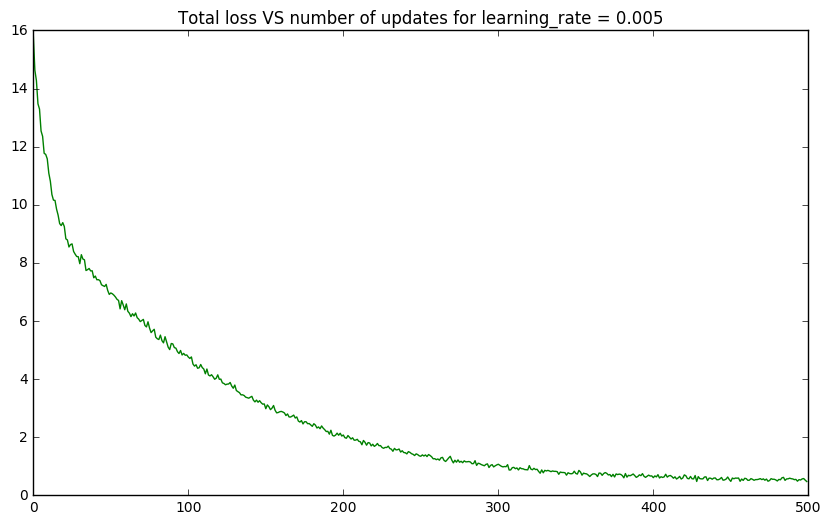

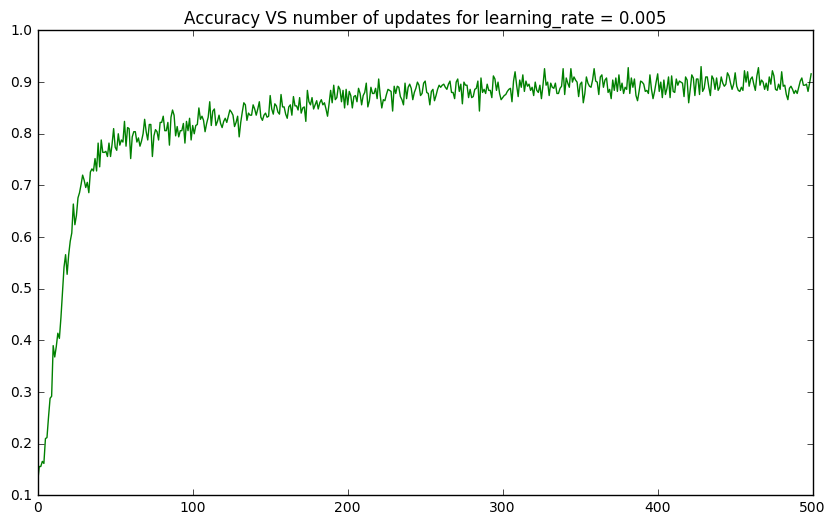

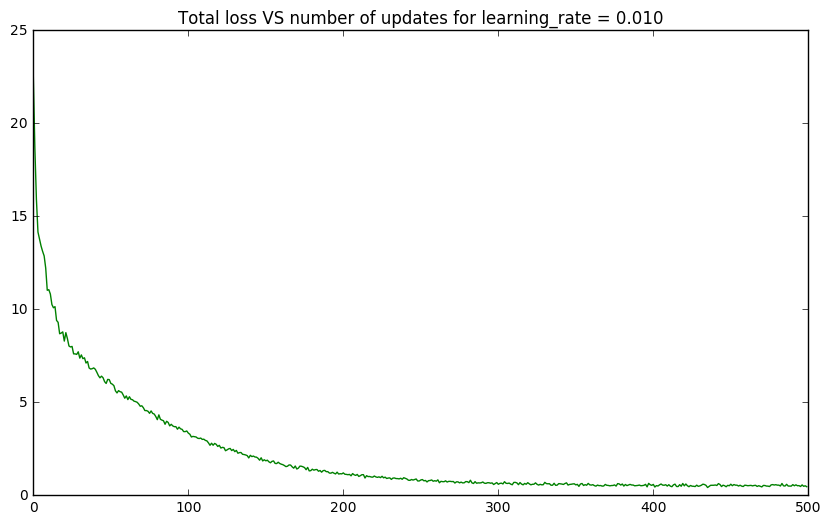

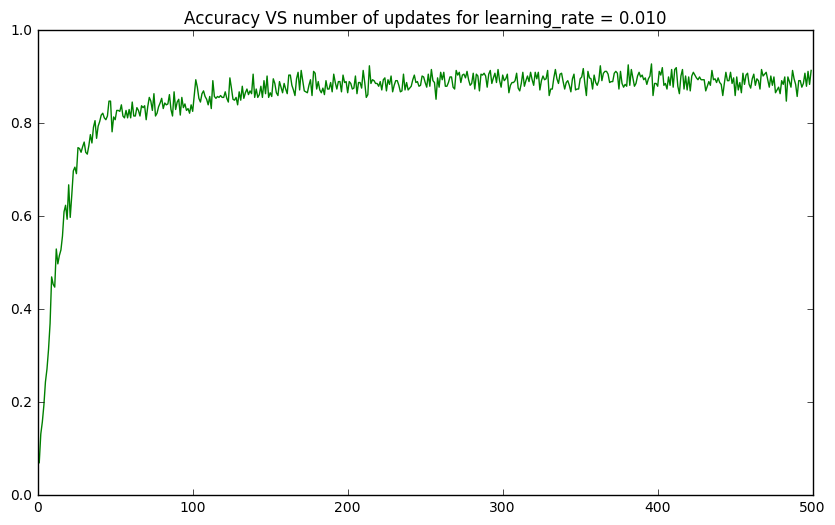

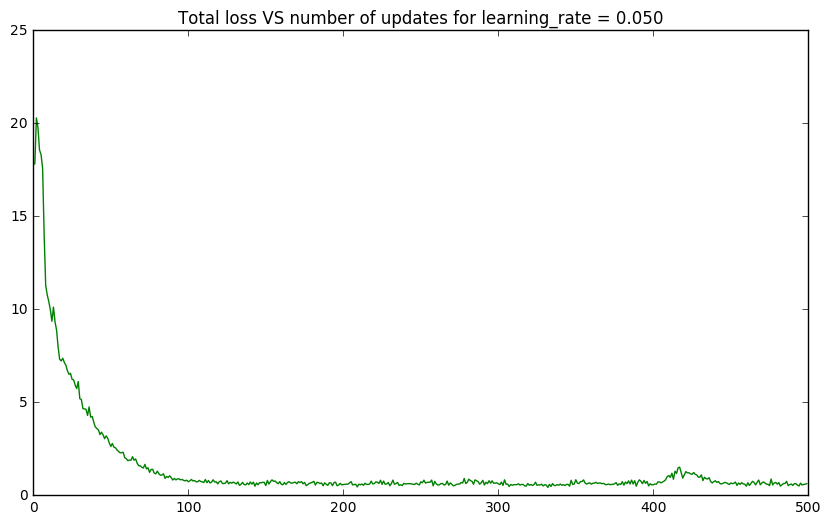

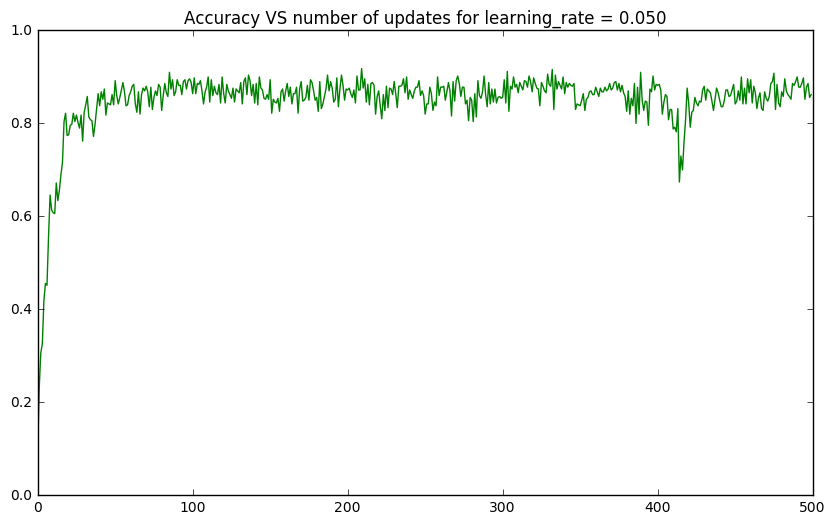

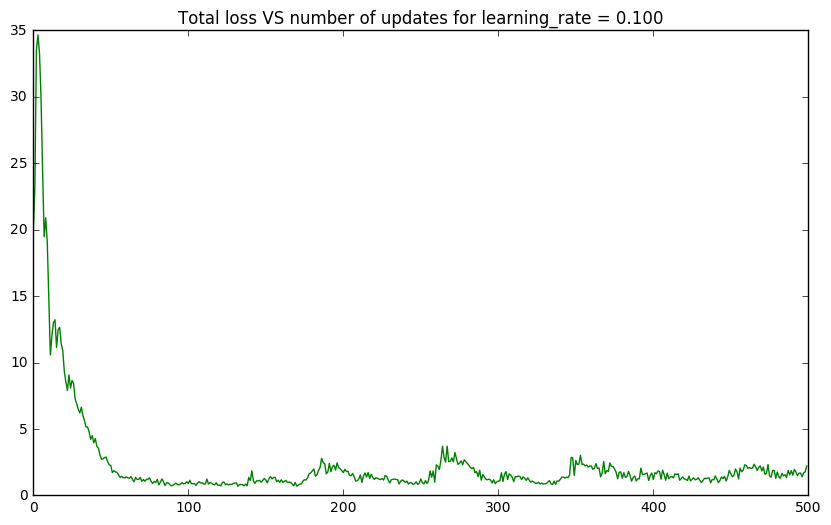

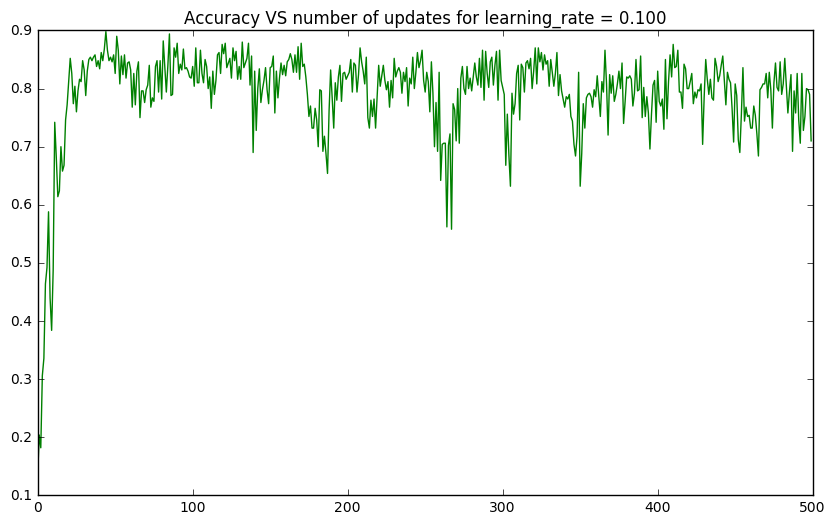

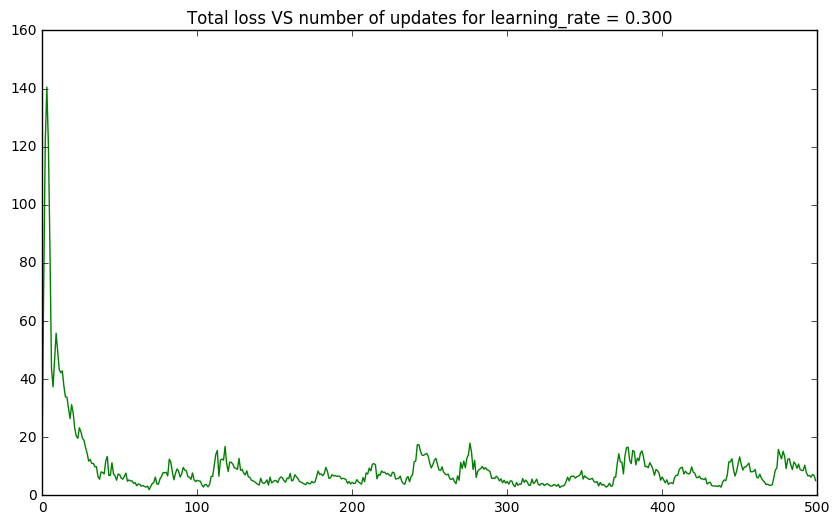

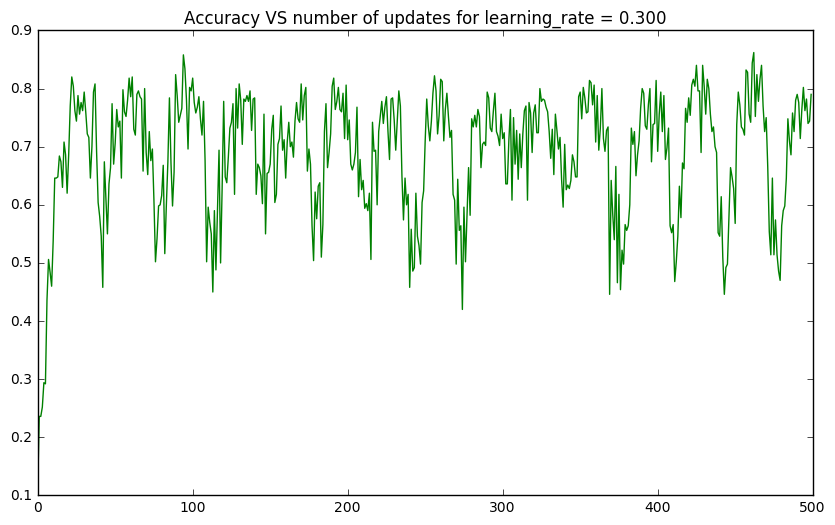

In [165]:
decay_rate = 0.01
batch_size = 500
learning_rate_list = [ 0.005, 0.01, 0.05, 0.1, 0.3]
for learning_rate in learning_rate_list: 
    W, b, X, y_target, y_predicted, error, train, acc = buildGraph_Adam(decay_rate, learning_rate)
    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    acc_recorder = np.array([])
    
    numIteration = 500
    for itr in range(numIteration):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
        loss_recorder = np.append(loss_recorder, loss)
        acc_recorder = np.append(acc_recorder, accuracy)
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
    plt.show()
    
    plt.plot(np.arange(numIteration), acc_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Accuracy VS number of updates for learning_rate = %0.3f"%(learning_rate))
    plt.show()

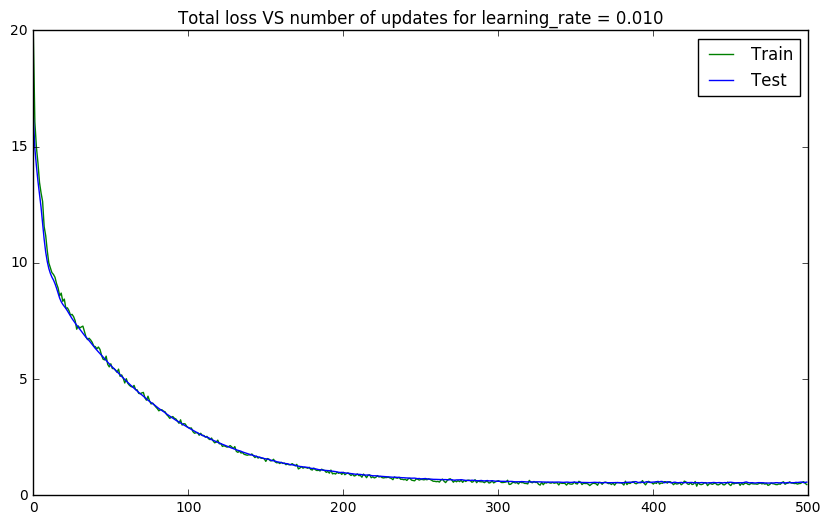

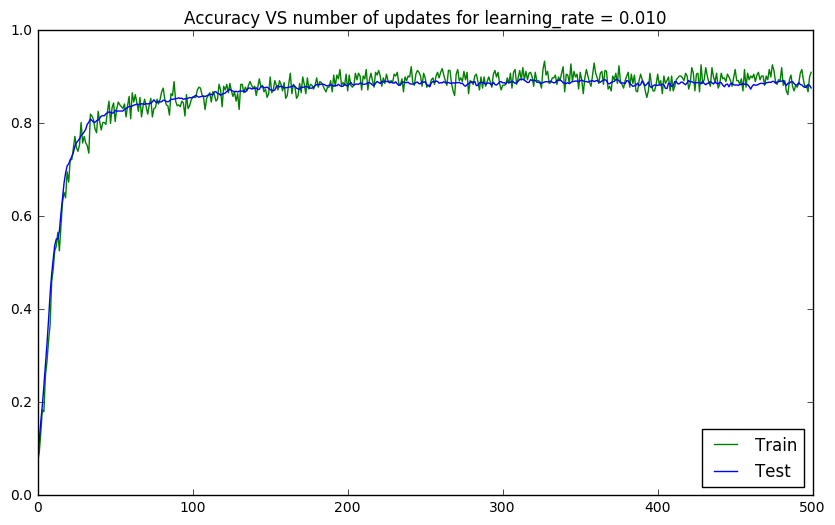

Best accuracy in test set is 0.90


In [119]:
decay_rate = 0.01
batch_size = 500
learning_rate = 0.01
#best learning rate 0.01
W, b, X, y_target, y_predicted, error, train, acc = buildGraph_Adam(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
train_loss_recorder = np.array([])
train_acc_recorder = np.array([])
test_loss_recorder = np.array([])
test_acc_recorder = np.array([])
numIteration = 500
best_acc = 0
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    train_loss_recorder = np.append(train_loss_recorder, loss)
    train_acc_recorder = np.append(train_acc_recorder, accuracy)
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    test_loss_recorder = np.append(test_loss_recorder, test_loss)
    test_acc_recorder = np.append(test_acc_recorder, test_acc)
    best_acc = max(best_acc, test_acc)
plt.plot(np.arange(numIteration), train_loss_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), test_loss_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

plt.plot(np.arange(numIteration), train_acc_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), test_acc_recorder, 'b', label="Test")
plt.legend(loc="lower right")
#plt.axis([0,500, 0, 2])
plt.title("Accuracy VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

print("Best accuracy in test set is %0.2f"%(best_acc))

<p>Its accuracy is lower than the binary classification problems. Because we need to classify 10 classes in this problem, it makes sense to get a lower accruacy using the same method as last problem.</p>

<h2>2.2</h2>

<h3>2.2.1</h3>

In [155]:
def layerBlock(x, n_units, decay_rate):
    '''
    x:input tensor
    n_units:number of hidden units in this layer
    '''
    n_input = x.get_shape().as_list()[1]
    XavierSTD = np.sqrt(3.0 / (n_input + n_units))
    W = tf.Variable(tf.truncated_normal(shape=[n_input, n_units], stddev=XavierSTD), name="weights")
    b = tf.Variable(tf.zeros([n_units]), name="biases")
    weight_decay = tf.reduce_sum(tf.scalar_mul(decay_rate, tf.nn.l2_loss(W)))
    #tf.add_to_collection('losses', weight_decay)
    z = tf.add(tf.matmul(x, W), b)
    return z

<h3>2.2.2</h3>

In [156]:
# Parameters
learning_rate_list = [0.001, 0.01, 0.1]
batch_size = 100
display_step = 1
decay_rate = 3e-4
# Network Parameters
n_hidden_1 = 1000 # 1st layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10

In [46]:
tf.reset_default_graph()
tf.add_to_collection('test', 1010)
tf.get_collection('test')

[1010]

In [157]:
def buildGraph(decay_rate, learning_rate):
    X = tf.placeholder(tf.float32, [None, 784], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,10], name='target_y')

    # Graph definition
    layer_1 = layerBlock(X, n_hidden_1, decay_rate)
    layer_1 = tf.nn.relu(layer_1)
    out_layer = layerBlock(layer_1, n_classes, decay_rate)
    y_predicted = out_layer

    # Error definition
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_target, logits = y_predicted))
     #           tf.add_n(tf.get_collection('losses'))
        
    correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y_target,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return X, y_target, y_predicted, error, train, acc

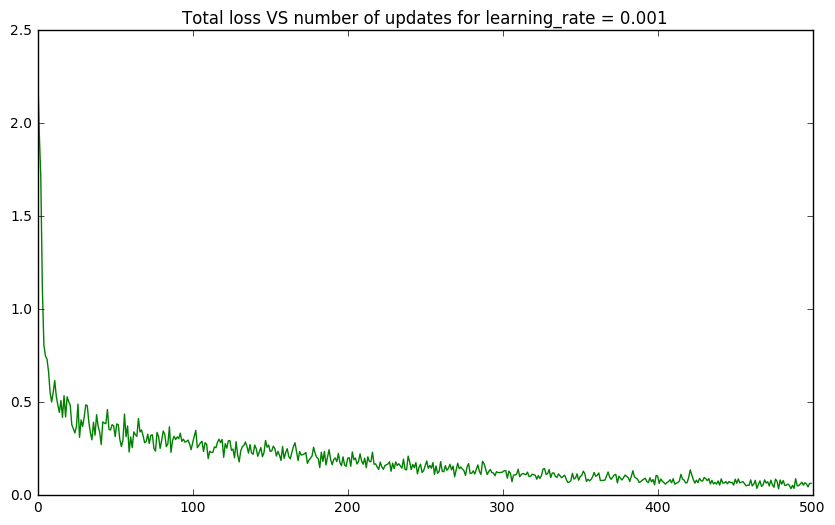

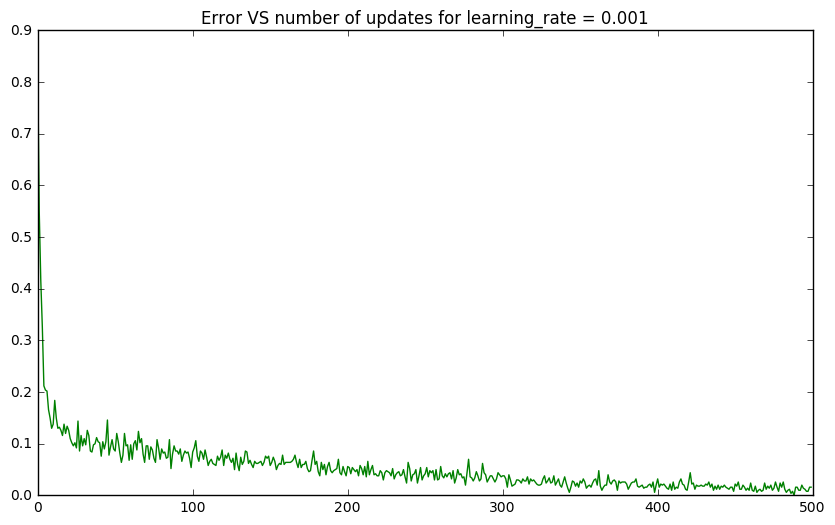

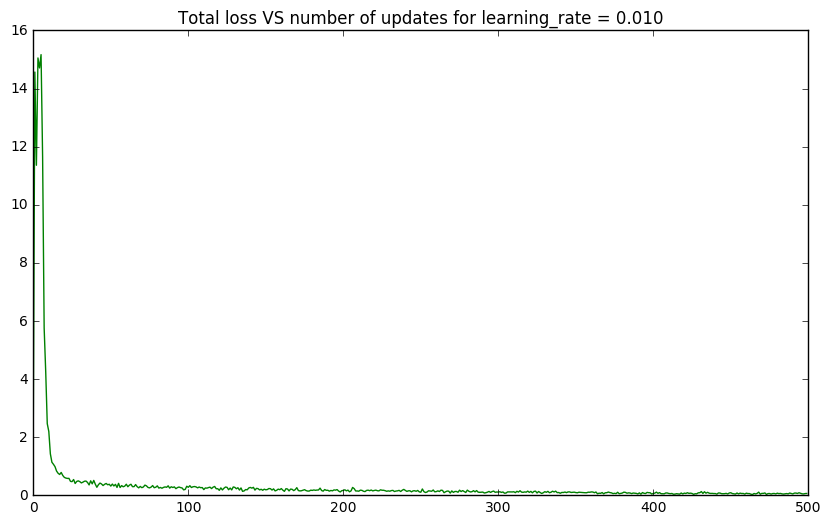

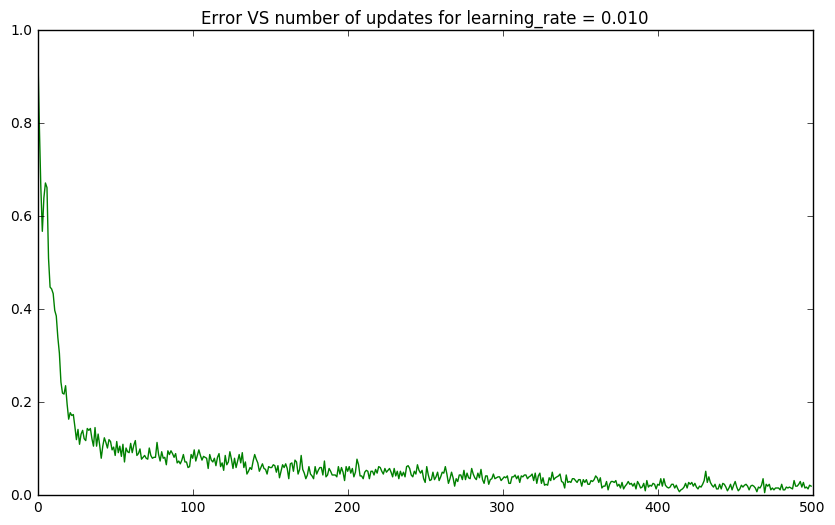

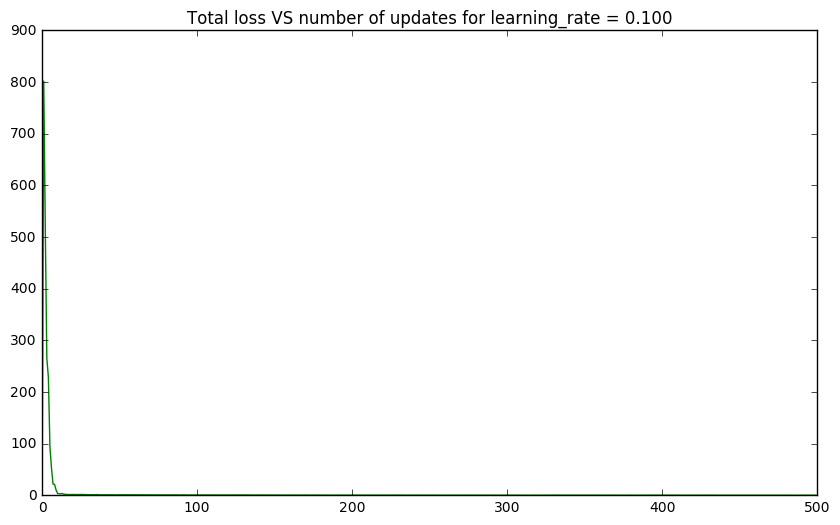

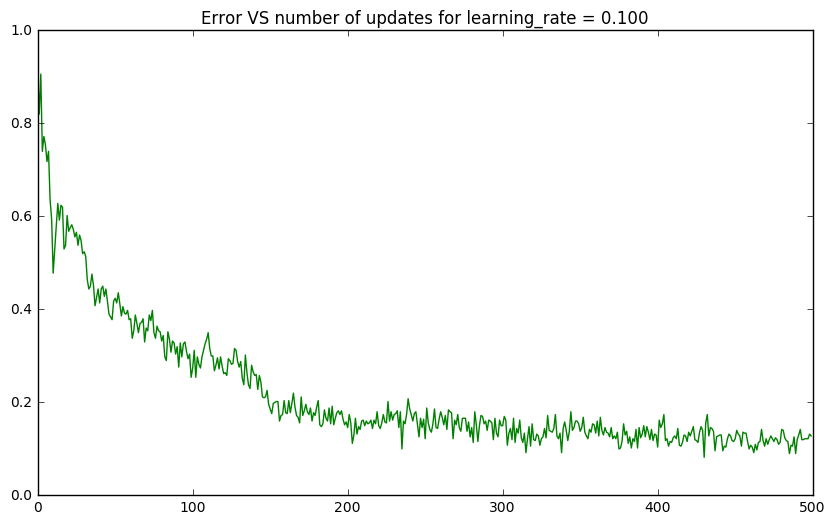

In [159]:
for learning_rate in learning_rate_list:
    tf.reset_default_graph()
    X, y_target, y_predicted, error, train, acc = buildGraph(decay_rate, learning_rate)
    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    mis_recorder = np.array([])
    
    numIteration = 500
    for itr in range(numIteration):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
        loss_recorder = np.append(loss_recorder, loss)
        mis_recorder = np.append(mis_recorder, 1.0 - accuracy)
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
    plt.show()
    
    plt.plot(np.arange(numIteration), mis_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Error VS number of updates for learning_rate = %0.3f"%(learning_rate))
    plt.show()

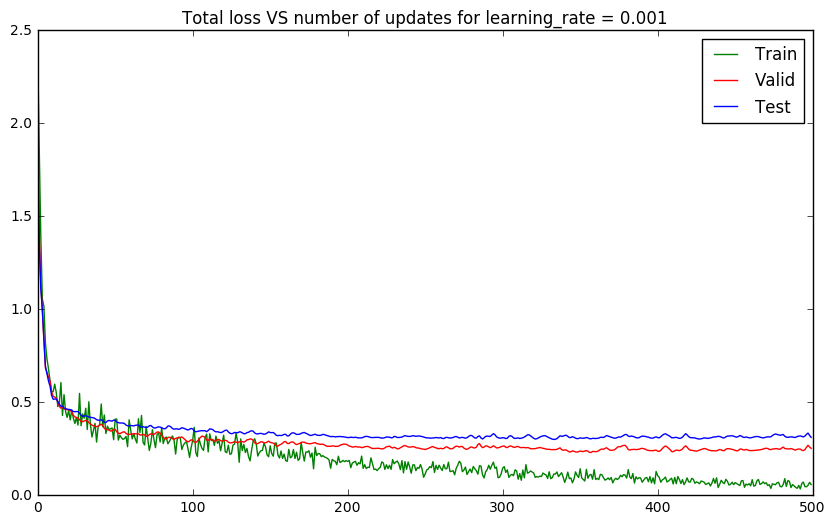

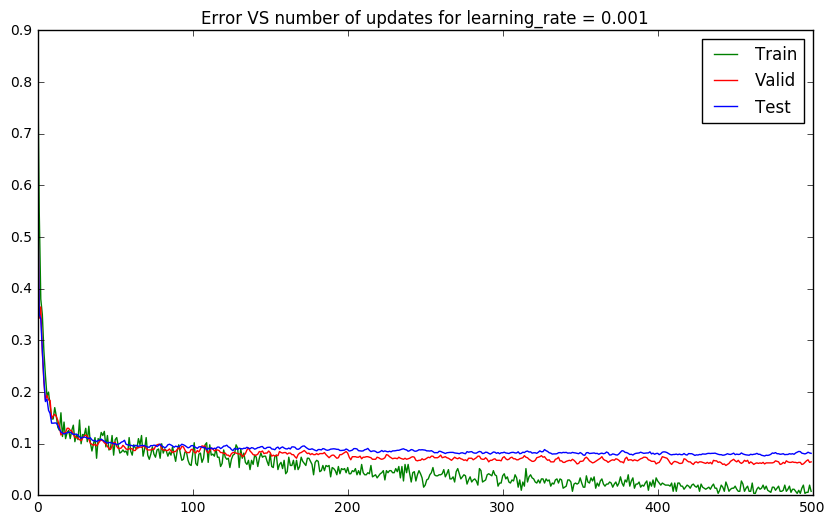

Best accuracy in test set is 0.92


In [158]:
decay_rate = 3e-4
batch_size = 500
learning_rate = 0.001
#best learning rate 0.001
tf.reset_default_graph()
X, y_target, y_predicted, error, train, acc = buildGraph(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
train_loss_recorder = np.array([])
train_mis_recorder = np.array([])
valid_loss_recorder = np.array([])
valid_mis_recorder = np.array([])
test_loss_recorder = np.array([])
test_mis_recorder = np.array([])
numIteration = 500
best_acc = 0
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    train_loss_recorder = np.append(train_loss_recorder, loss)
    train_mis_recorder = np.append(train_mis_recorder, 1.0 - accuracy)
    
    valid_loss, valid_acc = sess.run([error, acc], feed_dict={X: validData, y_target: validTarget})
    valid_loss_recorder = np.append(valid_loss_recorder, valid_loss)
    valid_mis_recorder = np.append(valid_mis_recorder, 1.0 - valid_acc)
    
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    test_loss_recorder = np.append(test_loss_recorder, test_loss)
    test_mis_recorder = np.append(test_mis_recorder, 1.0 - test_acc)
    
    best_acc = max(best_acc, test_acc)
    
plt.plot(np.arange(numIteration), train_loss_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), valid_loss_recorder, 'r', label="Valid")
plt.plot(np.arange(numIteration), test_loss_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

plt.plot(np.arange(numIteration), train_mis_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), valid_mis_recorder, 'r', label="Valid")
plt.plot(np.arange(numIteration), test_mis_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Error VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

print("Best accuracy in test set is %0.2f"%(best_acc))

<h2>2.3</h2>

<h3>2.3.1</h3>

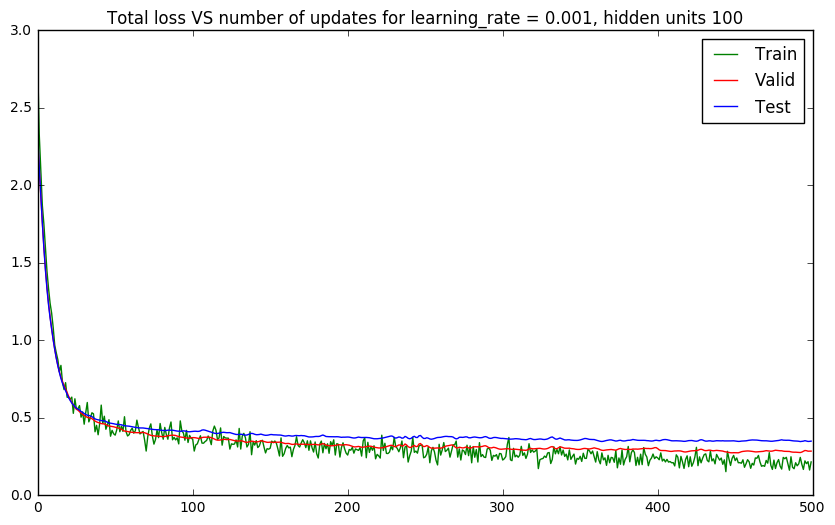

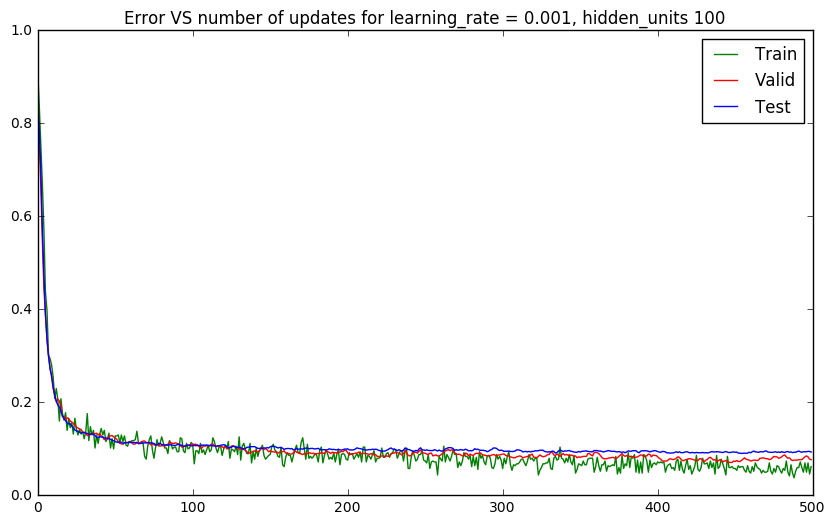

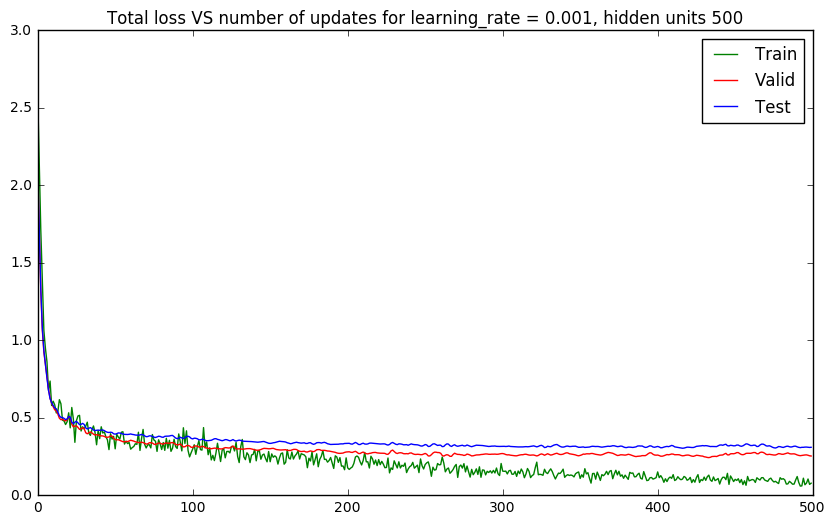

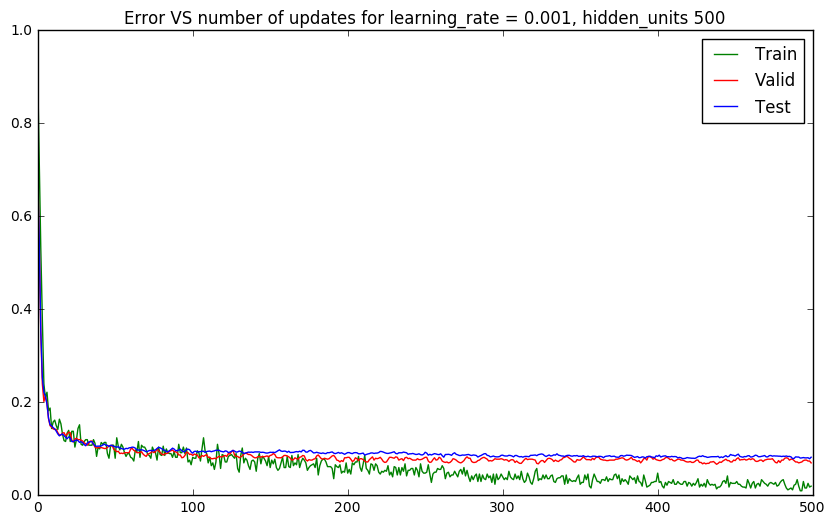

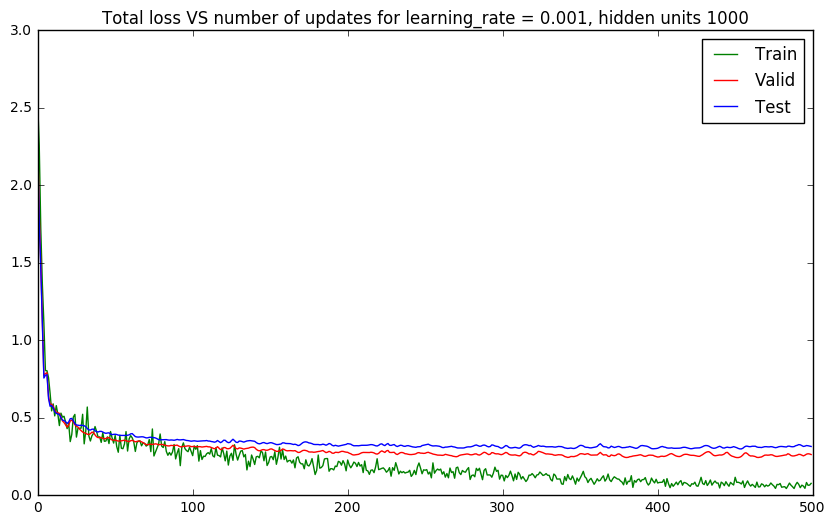

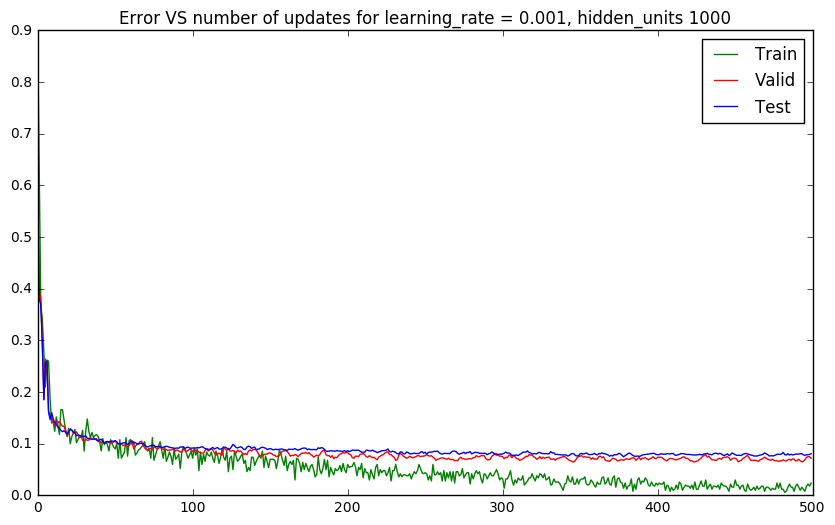

In [162]:
hidden_n_list = [100, 500, 1000]
best_valid_error = 1.0
best_n_hidden = 0
batch_size = 500
for hidden_n in hidden_n_list:
    n_hidden_1 = hidden_n
    tf.reset_default_graph()
    X, y_target, y_predicted, error, train, acc = buildGraph(decay_rate, learning_rate)
    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    train_loss_recorder = np.array([])
    train_mis_recorder = np.array([])
    valid_loss_recorder = np.array([])
    valid_mis_recorder = np.array([])
    test_loss_recorder = np.array([])
    test_mis_recorder = np.array([])
    
    numIteration = 500
    cur_valid_mis = 1.0
    for itr in range(numIteration):
        batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
        accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
        train_loss_recorder = np.append(train_loss_recorder, loss)
        train_mis_recorder = np.append(train_mis_recorder, 1.0 - accuracy)
        
        valid_loss, valid_acc = sess.run([error, acc], feed_dict={X: validData, y_target: validTarget})
        valid_loss_recorder = np.append(valid_loss_recorder, valid_loss)
        valid_mis_recorder = np.append(valid_mis_recorder, 1.0 - valid_acc)
    
        test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
        test_loss_recorder = np.append(test_loss_recorder, test_loss)
        test_mis_recorder = np.append(test_mis_recorder, 1.0 - test_acc)
    plt.plot(np.arange(numIteration), train_loss_recorder, 'g', label="Train")
    plt.plot(np.arange(numIteration), valid_loss_recorder, 'r', label="Valid")
    plt.plot(np.arange(numIteration), test_loss_recorder, 'b', label="Test")
    plt.legend()
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss VS number of updates for learning_rate = %0.3f, hidden units %d"%(learning_rate, hidden_n))
    plt.show()

    plt.plot(np.arange(numIteration), train_mis_recorder, 'g', label="Train")
    plt.plot(np.arange(numIteration), valid_mis_recorder, 'r', label="Valid")
    plt.plot(np.arange(numIteration), test_mis_recorder, 'b', label="Test")
    plt.legend()
    #plt.axis([0,500, 0, 2])
    plt.title("Error VS number of updates for learning_rate = %0.3f, hidden_units %d"%(learning_rate, hidden_n))
    plt.show()

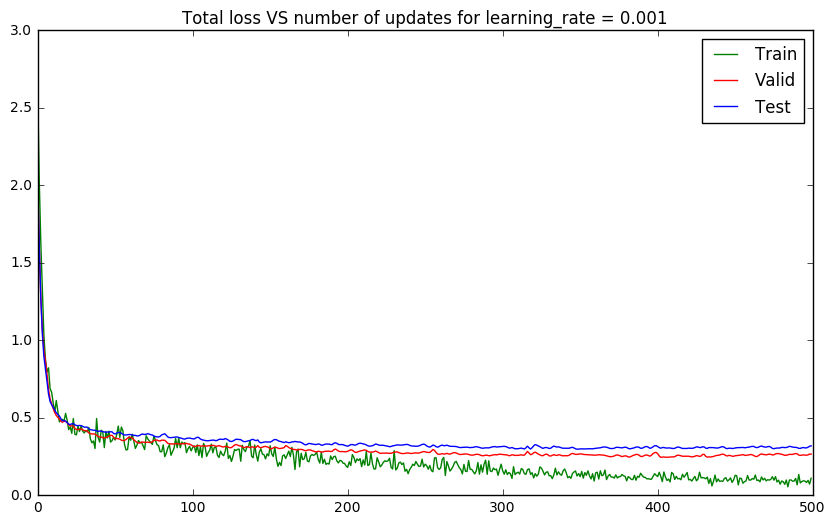

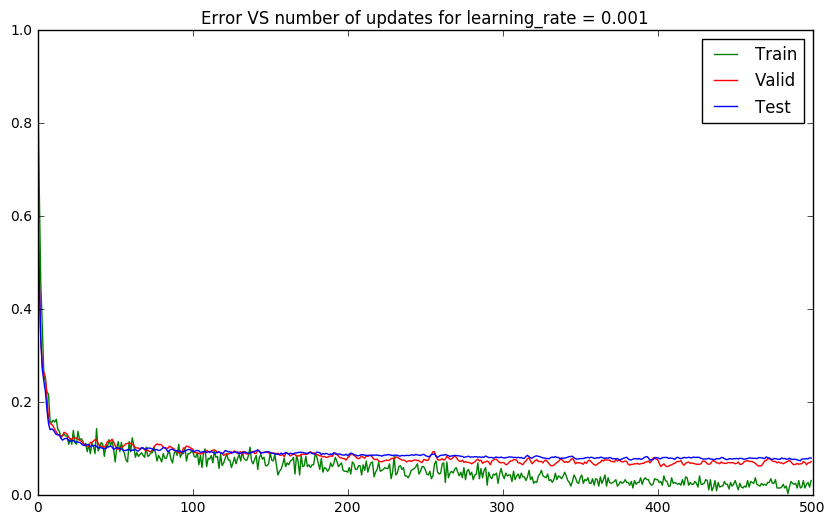

Best accuracy in test set is 0.93


In [163]:
decay_rate = 3e-4
batch_size = 500
learning_rate = 0.001
n_hidden_1 = 500
#best learning rate 0.001, number of hidden units 500
tf.reset_default_graph()
X, y_target, y_predicted, error, train, acc = buildGraph(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
train_loss_recorder = np.array([])
train_mis_recorder = np.array([])
valid_loss_recorder = np.array([])
valid_mis_recorder = np.array([])
test_loss_recorder = np.array([])
test_mis_recorder = np.array([])
numIteration = 500
best_acc = 0
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    train_loss_recorder = np.append(train_loss_recorder, loss)
    train_mis_recorder = np.append(train_mis_recorder, 1.0 - accuracy)
    
    valid_loss, valid_acc = sess.run([error, acc], feed_dict={X: validData, y_target: validTarget})
    valid_loss_recorder = np.append(valid_loss_recorder, valid_loss)
    valid_mis_recorder = np.append(valid_mis_recorder, 1.0 - valid_acc)
    
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    test_loss_recorder = np.append(test_loss_recorder, test_loss)
    test_mis_recorder = np.append(test_mis_recorder, 1.0 - test_acc)
    
    best_acc = max(best_acc, test_acc)
    
plt.plot(np.arange(numIteration), train_loss_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), valid_loss_recorder, 'r', label="Valid")
plt.plot(np.arange(numIteration), test_loss_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

plt.plot(np.arange(numIteration), train_mis_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), valid_mis_recorder, 'r', label="Valid")
plt.plot(np.arange(numIteration), test_mis_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Error VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

print("Best accuracy in test set is %0.2f"%(best_acc))

<h3>2.3.2</h3>

In [164]:
# Network Parameters
n_hidden_1 = 500
n_hidden_2 = 500
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10

def buildGraph(decay_rate, learning_rate):
    X = tf.placeholder(tf.float32, [None, 784], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,10], name='target_y')
    
    # Graph definition
    layer_1 = layerBlock(X, n_hidden_1, decay_rate)
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = layerBlock(layer_1, n_hidden_2, decay_rate)
    layer_2 = tf.nn.relu(layer_2)
    out_layer = layerBlock(layer_2, n_classes, decay_rate)
    y_predicted = out_layer

    # Error definition
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_target, logits = y_predicted)) +
                tf.add_n(tf.get_collection('losses'))
        
    correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y_target,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return X, y_target, y_predicted, error, train, acc

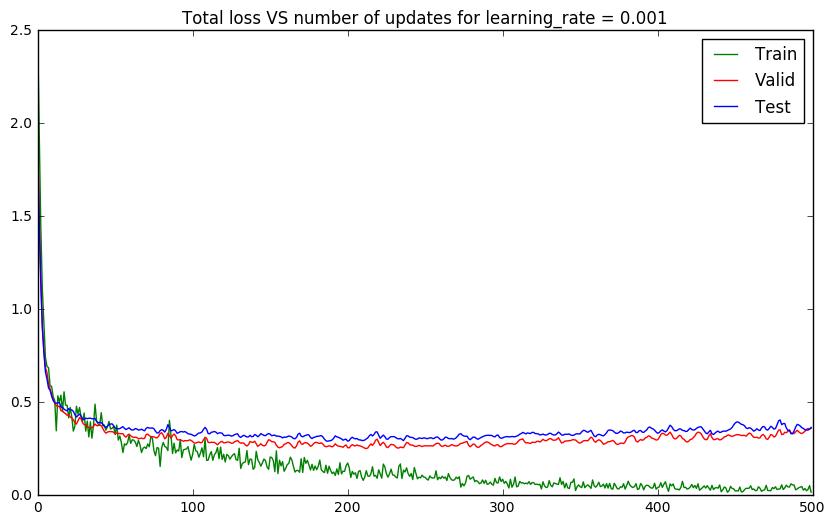

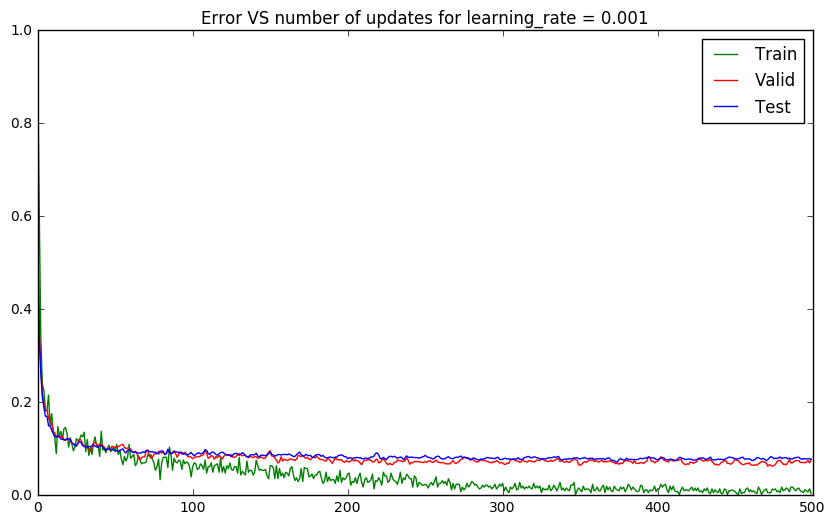

Best accuracy in test set is 0.93


In [165]:
decay_rate = 3e-4
batch_size = 500
learning_rate = 0.001
#best learning rate 0.001, number of hidden units 500
tf.reset_default_graph()
X, y_target, y_predicted, error, train, acc = buildGraph(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
train_loss_recorder = np.array([])
train_mis_recorder = np.array([])
valid_loss_recorder = np.array([])
valid_mis_recorder = np.array([])
test_loss_recorder = np.array([])
test_mis_recorder = np.array([])
numIteration = 500
best_acc = 0
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss, _ = sess.run([acc, error, train], feed_dict={X: batch_xs, y_target: batch_ys})
    train_loss_recorder = np.append(train_loss_recorder, loss)
    train_mis_recorder = np.append(train_mis_recorder, 1.0 - accuracy)
    
    valid_loss, valid_acc = sess.run([error, acc], feed_dict={X: validData, y_target: validTarget})
    valid_loss_recorder = np.append(valid_loss_recorder, valid_loss)
    valid_mis_recorder = np.append(valid_mis_recorder, 1.0 - valid_acc)
    
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget})
    test_loss_recorder = np.append(test_loss_recorder, test_loss)
    test_mis_recorder = np.append(test_mis_recorder, 1.0 - test_acc)
    
    best_acc = max(best_acc, test_acc)
    
plt.plot(np.arange(numIteration), train_loss_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), valid_loss_recorder, 'r', label="Valid")
plt.plot(np.arange(numIteration), test_loss_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

plt.plot(np.arange(numIteration), train_mis_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), valid_mis_recorder, 'r', label="Valid")
plt.plot(np.arange(numIteration), test_mis_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Error VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

print("Best accuracy in test set is %0.2f"%(best_acc))

<h2>2.4</h2>

<h3>2.4.1</h3>

In [166]:
# Network Parameters
n_hidden_1 = 500
n_hidden_2 = 500
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10
tf.reset_default_graph()
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
def buildGraph(decay_rate, learning_rate):
    X = tf.placeholder(tf.float32, [None, 784], name='input_x')
    y_target = tf.placeholder(tf.float32, [None,10], name='target_y')
    
    # Graph definition
    layer_1 = layerBlock(X, n_hidden_1, decay_rate)
    layer_1 = tf.nn.relu(layer_1)
    dropout_1 = tf.nn.dropout(layer_1, keep_prob)
    
    layer_2 = layerBlock(dropout_1, n_hidden_2, decay_rate)
    layer_2 = tf.nn.relu(layer_2)
    dropout_2 = tf.nn.dropout(layer_2, keep_prob)
    
    out_layer = layerBlock(dropout_2, n_classes, decay_rate)
    y_predicted = out_layer

    # Error definition
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_target, logits = y_predicted)) 
           #     tf.add_n(tf.get_collection('losses'))
        
    correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y_target,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(loss=error)
    return X, y_target, y_predicted, error, train, acc

step 0, training accuracy 0.126, test set accuracy 0.127753
step 100, training accuracy 0.914, test set accuracy 0.905286
step 200, training accuracy 0.92, test set accuracy 0.914831
step 300, training accuracy 0.946, test set accuracy 0.916667
step 400, training accuracy 0.944, test set accuracy 0.9163


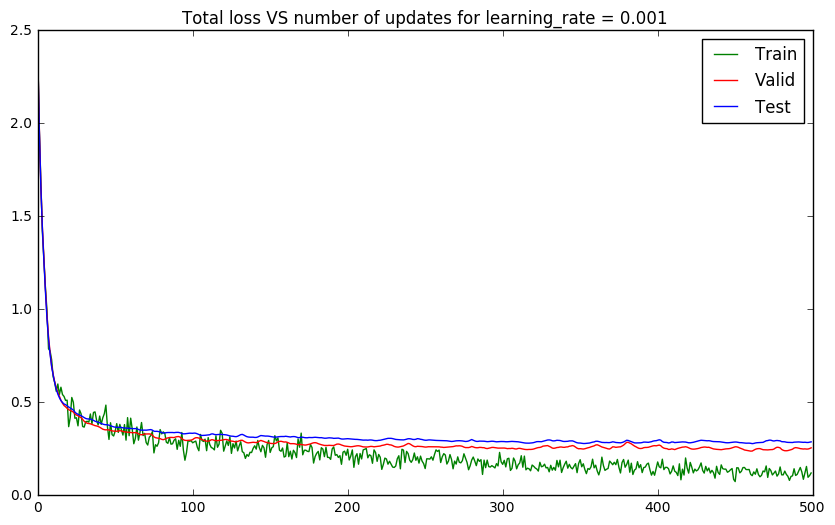

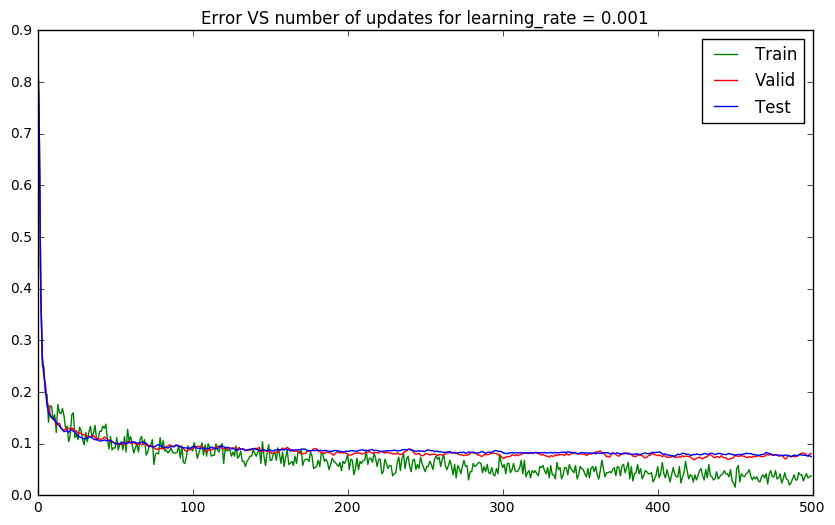

Best accuracy in test set is 0.93


In [167]:
decay_rate = 3e-4
batch_size = 500
learning_rate = 0.001
#best learning rate 0.001, number of hidden units 500
X, y_target, y_predicted, error, train, acc = buildGraph(decay_rate, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
train_loss_recorder = np.array([])
train_mis_recorder = np.array([])
valid_loss_recorder = np.array([])
valid_mis_recorder = np.array([])
test_loss_recorder = np.array([])
test_mis_recorder = np.array([])
numIteration = 500
best_acc = 0
for itr in range(numIteration):
    batch_xs, batch_ys = getRandomBatch(trainData, trainTarget, batch_size)
    accuracy, loss = sess.run([acc, error], feed_dict={X: batch_xs, y_target: batch_ys, keep_prob: 1.0})
    train_loss_recorder = np.append(train_loss_recorder, loss)
    train_mis_recorder = np.append(train_mis_recorder, 1.0 - accuracy)
        
    valid_loss, valid_acc = sess.run([error, acc], feed_dict={X: validData, y_target: validTarget, keep_prob: 1.0})
    valid_loss_recorder = np.append(valid_loss_recorder, valid_loss)
    valid_mis_recorder = np.append(valid_mis_recorder, 1.0 - valid_acc)
    
    test_loss, test_acc = sess.run([error, acc], feed_dict={X: testData, y_target: testTarget, keep_prob: 1.0})
    test_loss_recorder = np.append(test_loss_recorder, test_loss)
    test_mis_recorder = np.append(test_mis_recorder, 1.0 - test_acc)
    
    if itr % 100 == 0:
        print("step %d, training accuracy %g, test set accuracy %g"%(itr, accuracy, test_acc))
        
    best_acc = max(best_acc, test_acc)
    sess.run(train, feed_dict={X: batch_xs, y_target: batch_ys, keep_prob: 0.5})

    
plt.plot(np.arange(numIteration), train_loss_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), valid_loss_recorder, 'r', label="Valid")
plt.plot(np.arange(numIteration), test_loss_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

plt.plot(np.arange(numIteration), train_mis_recorder, 'g', label="Train")
plt.plot(np.arange(numIteration), valid_mis_recorder, 'r', label="Valid")
plt.plot(np.arange(numIteration), test_mis_recorder, 'b', label="Test")
plt.legend()
#plt.axis([0,500, 0, 2])
plt.title("Error VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

print("Best accuracy in test set is %0.2f"%(best_acc))

<p>From the plot we can see dropout effectively prevents overfit problem in the training set. Its accuracy improves to 93%</p>